[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/GANs-ANN.ipynb)


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision.utils import make_grid

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
LATENT_DIM = 64 # noisy input dimentions
IM_CHANNELS = 1 # no of channels in image = 1 cause black and white
IM_SIZE = (28, 28)

cuda


## Dataset

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=128, shuffle=True) # loading the downloaded dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 161368205.26it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 55287856.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34960880.19it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3541648.78it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



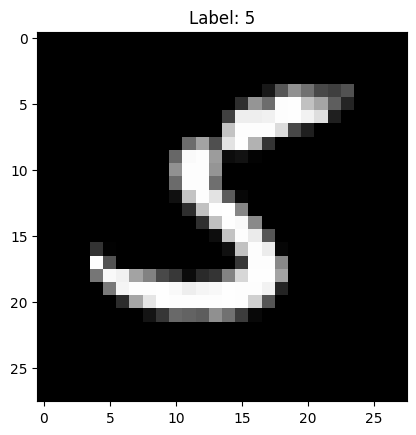

In [ ]:
# Display one image from one of the batches
images, labels = next(iter(mnist_loader)) # Extract one batch of images and labels
image = images[0].numpy().squeeze() # loading the one image from that batch
label = labels[0].item() # loading the actual label of the above image

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Modelling

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.latent_dim = LATENT_DIM
        self.img_size = IM_SIZE
        self.channels = IM_CHANNELS

        # input layer units = 64, hidden layer 1 units = 128, hidden layer 2 units = 256, output layer units = 28*28*1 = 784
        input_layer = nn.Sequential(nn.Linear(self.latent_dim, 128),nn.BatchNorm1d(128),nn.LeakyReLU())
        hidden_layer_1 = nn.Sequential(nn.Linear(128, 256),nn.BatchNorm1d(256),nn.LeakyReLU())
        hidden_layer_2 = nn.Sequential(nn.Linear(256, 512),nn.BatchNorm1d(512),nn.LeakyReLU())
        output_layer = nn.Sequential(nn.Linear(512, self.img_size[0] * self.img_size[1] * self.channels),nn.Identity(),nn.Tanh()) #tanh because we transformed the org img between 1 and -1 and hence predicted image should also be between 1 and -1 and hence tanh
        self.layers = nn.ModuleList([input_layer, hidden_layer_1, hidden_layer_2, output_layer])

    def forward(self, z):
        batch_size = z.shape[0]
        out = z.reshape(-1, self.latent_dim)
        for layer in self.layers:
            out = layer(out)
        out = out.reshape(batch_size, self.channels, self.img_size[0], self.img_size[1])
        return out

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.img_size = IM_SIZE
        self.channels = IM_CHANNELS

        input_layer = nn.Sequential(nn.Linear(self.img_size[0] * self.img_size[1] * self.channels, 512),nn.LayerNorm(512),nn.LeakyReLU())
        hidden_layer_1 = nn.Sequential(nn.Linear(512, 256),nn.LayerNorm(256),nn.LeakyReLU())
        hidden_layer_2 = nn.Sequential(nn.Linear(256, 128),nn.LayerNorm(128),nn.LeakyReLU())
        output_layer = nn.Sequential(nn.Linear(128, 1),nn.Identity(),nn.Sigmoid()) # Identity is used when you dont want any normalization
        self.layers = nn.ModuleList([input_layer, hidden_layer_1, hidden_layer_2, output_layer])

        # instead of layer norm here also you can use batch norm but layer norm gives better results

    def forward(self, x):
        # Flattening the image input
        out = x.reshape(-1, self.img_size[0] * self.img_size[1] * self.channels)
        for layer in self.layers:
            out = layer(out)
        return out

## Training

In [ ]:
from torch.optim import Adam

# Instantiate generator model
generator = Generator().to(device)
generator.train()
optimizer_generator = Adam(generator.parameters(), lr=1E-4, betas=(0.5, 0.999)) #0.5 is momentum

# Instantiate discriminator model
discriminator = Discriminator().to(device)
discriminator.train()
optimizer_discriminator = Adam(discriminator.parameters(), lr=1E-4, betas=(0.5, 0.999)) #0.5 is momentum

100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Finished epoch:1 | Generator Loss : 1.5126063207319296 | Discriminator Loss : 0.8998353359287482 | Discriminator real pred : 0.6650049884690404 | Discriminator fake pred : 0.5742057042081219


100%|██████████| 469/469 [00:17<00:00, 26.16it/s]


Finished epoch:2 | Generator Loss : 1.5088138068154422 | Discriminator Loss : 0.9009966991349324 | Discriminator real pred : 0.6650285270930861 | Discriminator fake pred : 0.5741559125975505


100%|██████████| 469/469 [00:18<00:00, 25.05it/s]


Finished epoch:3 | Generator Loss : 1.5104751866509412 | Discriminator Loss : 0.8996067375008231 | Discriminator real pred : 0.6650565954159572 | Discriminator fake pred : 0.5741807909916713


100%|██████████| 469/469 [00:18<00:00, 25.54it/s]


Finished epoch:4 | Generator Loss : 1.5287973740970149 | Discriminator Loss : 0.8949372374426836 | Discriminator real pred : 0.6655935087183645 | Discriminator fake pred : 0.573700167349915


100%|██████████| 469/469 [00:19<00:00, 23.83it/s]


Finished epoch:5 | Generator Loss : 1.5128273341193128 | Discriminator Loss : 0.8955386921541014 | Discriminator real pred : 0.6653864470117891 | Discriminator fake pred : 0.5737619504237226


100%|██████████| 469/469 [00:18<00:00, 25.46it/s]


Finished epoch:6 | Generator Loss : 1.525866698481635 | Discriminator Loss : 0.8963394015074284 | Discriminator real pred : 0.6654421956554405 | Discriminator fake pred : 0.5738371955052114


100%|██████████| 469/469 [00:18<00:00, 24.99it/s]


Finished epoch:7 | Generator Loss : 1.5254701697495954 | Discriminator Loss : 0.8894755882240816 | Discriminator real pred : 0.6657272620495956 | Discriminator fake pred : 0.5734290606431616


100%|██████████| 469/469 [00:18<00:00, 25.55it/s]


Finished epoch:8 | Generator Loss : 1.529805979621944 | Discriminator Loss : 0.8915125111272848 | Discriminator real pred : 0.6659008544136975 | Discriminator fake pred : 0.5733753911721935


100%|██████████| 469/469 [00:18<00:00, 25.42it/s]


Finished epoch:9 | Generator Loss : 1.5288115394140867 | Discriminator Loss : 0.8907892318930961 | Discriminator real pred : 0.6657658638730486 | Discriminator fake pred : 0.5732933709870524


100%|██████████| 469/469 [00:19<00:00, 24.61it/s]


Finished epoch:10 | Generator Loss : 1.5364307463804543 | Discriminator Loss : 0.8907496179344812 | Discriminator real pred : 0.6658357136539305 | Discriminator fake pred : 0.5733154540631309


100%|██████████| 469/469 [00:18<00:00, 25.53it/s]


Finished epoch:11 | Generator Loss : 1.5370530944897423 | Discriminator Loss : 0.8899212064011011 | Discriminator real pred : 0.665905074270041 | Discriminator fake pred : 0.5732823267166041


100%|██████████| 469/469 [00:18<00:00, 24.94it/s]


Finished epoch:12 | Generator Loss : 1.5379440804788553 | Discriminator Loss : 0.8884199672162152 | Discriminator real pred : 0.6660565867352841 | Discriminator fake pred : 0.572993920174743


100%|██████████| 469/469 [00:18<00:00, 25.82it/s]


Finished epoch:13 | Generator Loss : 1.5321286479547334 | Discriminator Loss : 0.8861426983052479 | Discriminator real pred : 0.6660755412665003 | Discriminator fake pred : 0.5729279551170529


100%|██████████| 469/469 [00:19<00:00, 23.99it/s]


Finished epoch:14 | Generator Loss : 1.5430871865896783 | Discriminator Loss : 0.8806520295041457 | Discriminator real pred : 0.6665431965134545 | Discriminator fake pred : 0.57253035744116


100%|██████████| 469/469 [00:18<00:00, 25.19it/s]


Finished epoch:15 | Generator Loss : 1.554306087590484 | Discriminator Loss : 0.8768248762657394 | Discriminator real pred : 0.6666434980404656 | Discriminator fake pred : 0.5723313621874812


100%|██████████| 469/469 [00:18<00:00, 24.89it/s]


Finished epoch:16 | Generator Loss : 1.553942660278857 | Discriminator Loss : 0.8769892269868587 | Discriminator real pred : 0.6667614032718927 | Discriminator fake pred : 0.5722008037414632


100%|██████████| 469/469 [00:18<00:00, 25.95it/s]


Finished epoch:17 | Generator Loss : 1.5560854925021435 | Discriminator Loss : 0.8788493853896412 | Discriminator real pred : 0.6666878849458593 | Discriminator fake pred : 0.5723466096656409


100%|██████████| 469/469 [00:18<00:00, 25.40it/s]


Finished epoch:18 | Generator Loss : 1.5638701329861622 | Discriminator Loss : 0.8790265439924146 | Discriminator real pred : 0.6667815894206196 | Discriminator fake pred : 0.5722274597265573


100%|██████████| 469/469 [00:18<00:00, 25.81it/s]


Finished epoch:19 | Generator Loss : 1.5581610050282753 | Discriminator Loss : 0.874338493799604 | Discriminator real pred : 0.666940993845844 | Discriminator fake pred : 0.5719489198503718


100%|██████████| 469/469 [00:18<00:00, 25.88it/s]


Finished epoch:20 | Generator Loss : 1.5602386229073824 | Discriminator Loss : 0.8738610394982133 | Discriminator real pred : 0.6671030414638235 | Discriminator fake pred : 0.5719333346972841


100%|██████████| 469/469 [00:18<00:00, 24.81it/s]


Finished epoch:21 | Generator Loss : 1.5717482099146731 | Discriminator Loss : 0.8706009268506504 | Discriminator real pred : 0.6674128245951524 | Discriminator fake pred : 0.571556983090667


100%|██████████| 469/469 [00:18<00:00, 26.05it/s]


Finished epoch:22 | Generator Loss : 1.5880346914598429 | Discriminator Loss : 0.8616263748231981 | Discriminator real pred : 0.6678214990762251 | Discriminator fake pred : 0.5709083006580247


100%|██████████| 469/469 [00:18<00:00, 25.31it/s]


Finished epoch:23 | Generator Loss : 1.5807901244682034 | Discriminator Loss : 0.8693918473939143 | Discriminator real pred : 0.6675449532232305 | Discriminator fake pred : 0.5712991630090579


100%|██████████| 469/469 [00:17<00:00, 26.43it/s]


Finished epoch:24 | Generator Loss : 1.5830432894641657 | Discriminator Loss : 0.859596682509888 | Discriminator real pred : 0.6681693702110095 | Discriminator fake pred : 0.570764575431596


100%|██████████| 469/469 [00:18<00:00, 25.62it/s]


Finished epoch:25 | Generator Loss : 1.593303986958095 | Discriminator Loss : 0.8606065441804654 | Discriminator real pred : 0.6681715560111918 | Discriminator fake pred : 0.5707337863918053


100%|██████████| 469/469 [00:18<00:00, 24.94it/s]


Finished epoch:26 | Generator Loss : 1.5957763240789808 | Discriminator Loss : 0.8608523849993627 | Discriminator real pred : 0.6680679106508999 | Discriminator fake pred : 0.5707218348344506


100%|██████████| 469/469 [00:17<00:00, 26.18it/s]


Finished epoch:27 | Generator Loss : 1.6026544817475115 | Discriminator Loss : 0.8558340570819911 | Discriminator real pred : 0.6684562405035186 | Discriminator fake pred : 0.5703449797020284


100%|██████████| 469/469 [00:18<00:00, 24.88it/s]


Finished epoch:28 | Generator Loss : 1.6063427853940138 | Discriminator Loss : 0.8599801268150558 | Discriminator real pred : 0.6682091136731064 | Discriminator fake pred : 0.570552963056544


100%|██████████| 469/469 [00:18<00:00, 25.95it/s]


Finished epoch:29 | Generator Loss : 1.614391202357278 | Discriminator Loss : 0.8508184162030088 | Discriminator real pred : 0.6688390350036784 | Discriminator fake pred : 0.5699747169195716


100%|██████████| 469/469 [00:18<00:00, 24.81it/s]


Finished epoch:30 | Generator Loss : 1.612443051993974 | Discriminator Loss : 0.8488863524851769 | Discriminator real pred : 0.6689347174884414 | Discriminator fake pred : 0.5696737645531514


100%|██████████| 469/469 [00:17<00:00, 26.21it/s]


Finished epoch:31 | Generator Loss : 1.6208497079959048 | Discriminator Loss : 0.8504370245089663 | Discriminator real pred : 0.6689917658691975 | Discriminator fake pred : 0.5697548050107732


100%|██████████| 469/469 [00:18<00:00, 25.71it/s]


Finished epoch:32 | Generator Loss : 1.626621399098622 | Discriminator Loss : 0.8458438866428221 | Discriminator real pred : 0.6692478190352922 | Discriminator fake pred : 0.5694257414925581


100%|██████████| 469/469 [00:18<00:00, 25.37it/s]


Finished epoch:33 | Generator Loss : 1.627213649531163 | Discriminator Loss : 0.8518870653374109 | Discriminator real pred : 0.6690169150895401 | Discriminator fake pred : 0.5696654174881958


100%|██████████| 469/469 [00:17<00:00, 26.08it/s]


Finished epoch:34 | Generator Loss : 1.6329164507546658 | Discriminator Loss : 0.8462743931996034 | Discriminator real pred : 0.6692501596296265 | Discriminator fake pred : 0.5693547963333536


100%|██████████| 469/469 [00:18<00:00, 24.83it/s]


Finished epoch:35 | Generator Loss : 1.636073667992915 | Discriminator Loss : 0.8444287147857487 | Discriminator real pred : 0.6694214793918992 | Discriminator fake pred : 0.5691917088748549


100%|██████████| 469/469 [00:17<00:00, 26.07it/s]


Finished epoch:36 | Generator Loss : 1.6343497608516262 | Discriminator Loss : 0.8415900612436632 | Discriminator real pred : 0.6695789707494951 | Discriminator fake pred : 0.5688482946170165


100%|██████████| 469/469 [00:18<00:00, 25.28it/s]


Finished epoch:37 | Generator Loss : 1.6410264521519513 | Discriminator Loss : 0.8335744408147929 | Discriminator real pred : 0.6702158705257912 | Discriminator fake pred : 0.5684050728263123


100%|██████████| 469/469 [00:18<00:00, 25.57it/s]


Finished epoch:38 | Generator Loss : 1.651795482965929 | Discriminator Loss : 0.8388591389666235 | Discriminator real pred : 0.6699029557994688 | Discriminator fake pred : 0.5684911219804272


100%|██████████| 469/469 [00:18<00:00, 24.87it/s]


Finished epoch:39 | Generator Loss : 1.6512926621223563 | Discriminator Loss : 0.8300576441323579 | Discriminator real pred : 0.6704320681374719 | Discriminator fake pred : 0.5680754676556536


100%|██████████| 469/469 [00:18<00:00, 25.78it/s]


Finished epoch:40 | Generator Loss : 1.6611310430427095 | Discriminator Loss : 0.8311793091200562 | Discriminator real pred : 0.6703997049758683 | Discriminator fake pred : 0.567971529101512


100%|██████████| 469/469 [00:17<00:00, 26.13it/s]


Finished epoch:41 | Generator Loss : 1.6606089317722361 | Discriminator Loss : 0.8310151491592179 | Discriminator real pred : 0.6705426709738367 | Discriminator fake pred : 0.567929444282548


100%|██████████| 469/469 [00:18<00:00, 24.94it/s]


Finished epoch:42 | Generator Loss : 1.670596733848169 | Discriminator Loss : 0.8335678590131975 | Discriminator real pred : 0.6704533799116545 | Discriminator fake pred : 0.5679993173206793


100%|██████████| 469/469 [00:18<00:00, 25.68it/s]


Finished epoch:43 | Generator Loss : 1.6698744248733846 | Discriminator Loss : 0.8228779324590524 | Discriminator real pred : 0.6710291033360496 | Discriminator fake pred : 0.5674558284440274


100%|██████████| 469/469 [00:18<00:00, 24.75it/s]


Finished epoch:44 | Generator Loss : 1.6670462495482552 | Discriminator Loss : 0.8275479149462571 | Discriminator real pred : 0.6708362694742329 | Discriminator fake pred : 0.5676833381022471


100%|██████████| 469/469 [00:17<00:00, 26.14it/s]


Finished epoch:45 | Generator Loss : 1.6782929552897716 | Discriminator Loss : 0.8202845610535221 | Discriminator real pred : 0.6712699013986567 | Discriminator fake pred : 0.5669837751622393


100%|██████████| 469/469 [00:19<00:00, 24.55it/s]


Finished epoch:46 | Generator Loss : 1.6754754270826067 | Discriminator Loss : 0.8219533477510724 | Discriminator real pred : 0.6712238666599494 | Discriminator fake pred : 0.5672900132787253


100%|██████████| 469/469 [00:17<00:00, 26.17it/s]


Finished epoch:47 | Generator Loss : 1.676150799051785 | Discriminator Loss : 0.8184069527237654 | Discriminator real pred : 0.6714220805717176 | Discriminator fake pred : 0.5668187784487759


100%|██████████| 469/469 [00:17<00:00, 26.07it/s]


Finished epoch:48 | Generator Loss : 1.6931102502066444 | Discriminator Loss : 0.8163348463044238 | Discriminator real pred : 0.6715758450504051 | Discriminator fake pred : 0.566695272159983


100%|██████████| 469/469 [00:18<00:00, 25.23it/s]


Finished epoch:49 | Generator Loss : 1.6922461469290353 | Discriminator Loss : 0.8153641255679669 | Discriminator real pred : 0.6716107047442943 | Discriminator fake pred : 0.5666070834660073


100%|██████████| 469/469 [00:17<00:00, 26.06it/s]


Finished epoch:50 | Generator Loss : 1.6992250736842531 | Discriminator Loss : 0.8151229917367638 | Discriminator real pred : 0.6717819133038714 | Discriminator fake pred : 0.5664109592752924


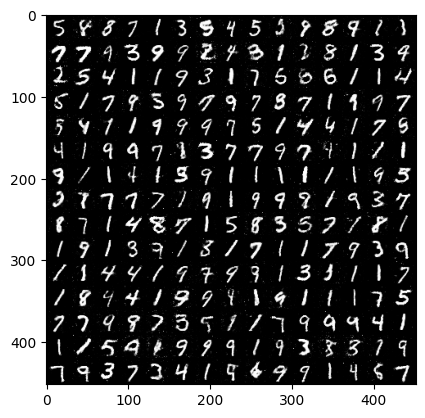

In [ ]:
steps = 0

for epoch in range(50): # for each epoch
    generator_losses = []
    discriminator_losses = []
    mean_real_dis_preds = []
    mean_fake_dis_preds = []

    for im, _ in tqdm(mnist_loader): # for each image in each epoch

        real_ims = im.float().to(device)
        batch_size = real_ims.shape[0]

        ''' ######################### First Optimizing the Discriminator ######################### '''

        optimizer_discriminator.zero_grad()

        fake_im_noise = torch.randn((batch_size, LATENT_DIM), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing the noisy data through the generator to get fake image
        disc_real_pred = discriminator(real_ims) # passing real image to the discriminator
        disc_fake_pred = discriminator(fake_ims.detach()) # passing fake image to the discriminator but we are detaching it so that gradients are not computed for generator and generator is not trained while training the discriminator

        disc_loss = -torch.mean(torch.log(disc_real_pred.reshape(-1) + 0.0001) + torch.log(1. - disc_fake_pred.reshape(-1) + 0.0001) )

        disc_loss.backward()
        optimizer_discriminator.step()

        mean_real_dis_preds.append(torch.nn.Sigmoid()(disc_real_pred).mean().item())
        mean_fake_dis_preds.append(torch.nn.Sigmoid()(disc_fake_pred).mean().item())


        ''' ######################### Second Optimizing the Generator ######################### '''
        optimizer_generator.zero_grad()

        fake_im_noise = torch.randn((batch_size, LATENT_DIM), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing through generator to create fake image
        disc_fake_pred = discriminator(fake_ims) # passing through discriminator to classify it as fake or real

        gen_fake_loss = -torch.mean(torch.log(disc_fake_pred.reshape(-1) + 0.0001))

        gen_fake_loss.backward()
        optimizer_generator.step()

        generator_losses.append(gen_fake_loss.item())
        discriminator_losses.append(disc_loss.item())

        ''' ######################### Seeing how the generator is improving with training ######################### '''
        if steps % 5 == 0:
            with torch.no_grad():
                generator.eval()

                NUM_SAMPLES = 225
                fake_im_noise = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device) # generating some noisy data
                fake_ims = generator(fake_im_noise) # generating image using generator
                ims = torch.clamp(fake_ims, -1., 1.).detach().cpu() # clamping the generated images
                ims = 0.5*ims + 0.5 #detransforming the images from [-1,1] to [0,1]
                grid = make_grid(ims, nrow=15)
                img = torchvision.transforms.ToPILImage()(grid)
                plt.imshow(img, cmap='gray') # now display the image here using matplot lib

                generator.train()
        steps += 1

    print(f'''Finished epoch:{epoch + 1} | Generator Loss : {np.mean(generator_losses)} | Discriminator Loss : {np.mean(discriminator_losses)} | Discriminator real pred : {np.mean(mean_real_dis_preds)} | Discriminator fake pred : {np.mean(mean_fake_dis_preds)}''')